In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from root_numpy import root2array
import Constants as C
from WeightTool import WeightTool
from matplotlib.colors import LogNorm

from PlotTool import PlotTool
from Cuts import qratio, getQAB, qlayerCut

In [6]:
# Load the data and apply selection

# Specify file paths
f_nue   = '../trees/NuGen_11068_Dec7_600files.root'

# Specify branches to load
branches = ['NPE','Nch','ImpLF_zen','ImpLF_rchi2', 
            'nuE','NEvents','OneWeight',
            'passHESE','q_out0','q_out1','q_out2','q_in',
            'hs_z_travel',
            'log10(hs_q_tot_pulses)', 'hm_nhit_doms','hm_nhit_strings',
            'hm_nhit_doms/hm_nhit_strings', 'log10(hs_q_tot_pulses)/hm_nhit_doms',
            'StrNearly5[0]',
             'rho_travel',
            'tlarge - tearly',
            'PrimaryNeutrinoEnergy'
            ]

# Put easy selection here
sel = '(!passHESE && NPE > 1000 && hm_nhit_doms>50 && hs_z_travel > -100 && hs_z_travel < 100 && rho_travel < 250 && nuE > 0)'
sel += '&&(tlarge - tearly < 200 && log10(hs_q_tot_pulses) >= 4.6)'
dt_new  = root2array(f_nue, treename="tree", branches=branches, selection=sel)
dt_hese = root2array(f_nue, treename="tree", branches=branches, selection='(passHESE && nuE>0)')

# Apply q-layer cut
dt_new = qlayerCut(dt_new, False, 0.8)

# Get weights
w_tool = WeightTool()
w_new  = w_tool.getAstroW(dt_new['nuE'], dt_new['OneWeight'], dt_new['NEvents'], C.nugen_nue_nfiles)
w_hese = w_tool.getAstroW(dt_hese['nuE'], dt_hese['OneWeight'], dt_hese['NEvents'], C.nugen_nue_nfiles)

# Put into pandas object
dt_new = pd.DataFrame(dt_new)
dt_hese = pd.DataFrame(dt_hese)

# Add weights
dt_new['w'] = pd.Series(w_new)
dt_hese['w'] = pd.Series(w_hese)

# Put the first hit into the frame
strings = [1,2,3,4,5,6,
           13,21,30,40,50,
           59,67,74,
           73,72,
           78,77,76,75,
           68,60,51,41,31,
           22,14,7]
def addfirsthit(data):
    data['firsthitout'] = pd.Series( data['StrNearly5[0]'].apply(lambda x: x in strings),
                                    index = data.index)
    return data[ data['firsthitout'] > 0.5]
    
dt_new = addfirsthit(dt_new)


In [7]:
# Check that the yields look ok
print "New selection: ", sum(dt_new['w']) * 365/34.7
print "HESE:          ", sum(dt_hese['w']) * 365/34.7
print "PeV New:       ", sum(dt_new[ dt_new['nuE'] > 1000000]['w'])


New selection:  1.26755139199
HESE:           3.61884487194
PeV New:        0.105868033196


In [10]:
# Methods to plot effective area
from math import pi,log10

xmin  = 3
xmax  = 7
nbins = 20.
bins = np.arange(3,9.1,0.3)
ebins_per_decade = float(nbins/(xmax-xmin))
solidangle = 4*pi

def mcLogEBin(E):
    return int(log10(E)*ebins_per_decade)
def mcEMin(mc_log_ebin):
    return pow(10,mc_log_ebin/ebins_per_decade)
def mcEMax(mc_log_ebin):
    return pow(10,(1+mc_log_ebin)/ebins_per_decade)

# Calculate effective area
def getEffA(data):
    effA = np.zeros(len(data['PrimaryNeutrinoEnergy']),dtype=float)
    energy = np.empty(len(data['PrimaryNeutrinoEnergy']),dtype=float)        
    fnorm  = 1. / (C.nugen_nue_nfiles)
    
    dt_E = data['PrimaryNeutrinoEnergy'].as_matrix()
    dt_oneweight = data['OneWeight'].as_matrix()
    dt_nevents   = data['NEvents'].as_matrix()
    for i in range(len(effA)):

        E = dt_E[i]
        OneWeight = dt_oneweight[i]
        NEvents   = dt_nevents[i]
        mclogebin = mcLogEBin(E)
        mcemin = mcEMin(mclogebin)
        mcemax = mcEMax(mclogebin)
        
        effA[i] = 1e-4 * OneWeight * fnorm/NEvents * 1/(solidangle*(mcemax-mcemin))
        energy[i] = log10(E)

    return effA, energy

def plotEffA(nrg, effa, col, lbl,ls='solid'):
        plt.hist(nrg,
                 weights=effa,
                 color=col,
                 label=lbl,
                 range=(xmin,xmax),
                 bins = nbins,
                 histtype='step',
                 lw = 1.5,
                ls = ls)


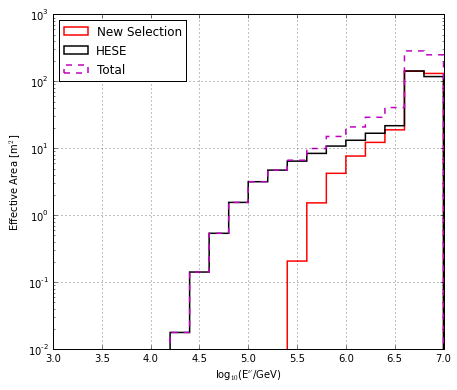

In [11]:
# Now plot the effective area
effA_new, e_new = getEffA(dt_new)
effA_hese, e_hese = getEffA(dt_hese)

fig, ax = plt.subplots(ncols=1,figsize=(7,6))
plotEffA(e_new, effA_new, 'r','New Selection')
plotEffA(e_hese,effA_hese,'black','HESE')
plotEffA(np.concatenate([e_hese,e_new]), 
         np.concatenate([effA_hese, effA_new]), 
         'm', "Total", 'dashed')

ax.set_ylim([1e-2,1e3])
ax.set_yscale('log')
plt.xlabel(r'log$_{10}$(E$^{\nu}$/GeV)')
plt.ylabel(r'Effective Area [m$^{2}$]')
plt.grid()

plt.legend(loc='upper left')
plt.savefig('../plots/cutsana/EffectiveArea/firstpasssel.png')

